In [10]:
import PEC_Parser
import numpy as np
import matplotlib.pyplot as plt 
import gym
import random

In [11]:
file_path = "pec_domains\complex_domains\\box_world_simple.txt"
file = open(file_path, "r")
domain_string = file.read()

### Box world domain

Box 1 starts at a, Box 2 at d and the deliveryman at c. Box 1 must be moved to d, Box 2 to b, and deliveryman must go back to c. The deliveryman can only carry one box in their truck at one time. Traveling along any road may result in getting lost and sent to one of the adjoining roads with a probability of 0.2.
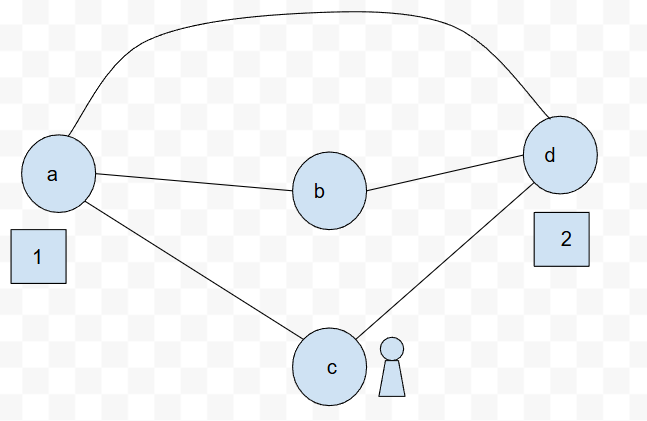

In [ ]:
# Define domain 

domain = PEC_Parser.domain()
domain.initialise_all(domain_string)

state_dict = domain.state_dict
reverse_state_dict = {v: k for k, v in state_dict.items()}
action_dict = domain.action_dict
reverse_action_dict = {v: k for k, v in action_dict.items()}
value_dict = domain.value_dict
reverse_value_dict = {v: k for k, v in value_dict.items()}
fluent_dict = domain.fluent_dict
reverse_fluent_dict = {v: k for k, v in fluent_dict.items()}

# Define dictionaries of integer states and literals
full_state_dict = {}
reversed_full_state_dict = {}
for i in range(len(state_dict)):
    full_state_dict[i] = domain.translate_int_to_lit(i)
    reversed_full_state_dict[domain.translate_int_to_lit(i)] = i
    
initial_distribution = domain.get_initial(domain_string)
transition_matrix = domain.get_transition(domain_string)
#n_steps = domain.max_instant

states = list(state_dict.values())
actions = list(action_dict.values())


Define states in which subgoals and the final goal are met.

In [13]:
# Define here some states where each goal has or has not been met

box_1_goal_states = set(domain.partial_to_states("box1_location=d"))
box_1_nongoal_states = set(states)-box_1_goal_states

box_2_goal_states = set(domain.partial_to_states("box2_location=b"))
box_2_nongoal_states = set(states)-box_2_goal_states

finish_states = set(domain.partial_to_states("box1_location=d, box2_location=b, location=c"))
non_finish_states = set(states)-finish_states

Define rewards:

* drive, load, unload, or do nothing all take -2

* getting one box to the right location is +20

* completing all tasks is +50

In [ ]:
class pecmdp():
    def __init__(self, states, actions, transition_probs, initial_probs):
        self.states = states
        self.actions = actions
        self.transition_probs = transition_probs
        self.initial_probs = initial_probs
    
    def _calculate_reward(self, current_state, action, next_state):
        """Calculate reward based on the environment dynamics"""
        reward = 0
        
        # Get action name from action index
        action_name = reverse_action_dict[action]
        
        # Define rewards
        if "drive" in action_name:
            reward += -2
        elif "load" in action_name or "unload" in action_name:
            reward += -2
        elif "null" in action_name:
            reward += -2
        elif next_state == current_state:
            reward += -2
        if current_state in box_1_nongoal_states and next_state in box_1_goal_states:
            reward += 20
        if current_state in box_2_nongoal_states and next_state in box_2_goal_states:
            reward += 20
        if current_state in non_finish_states and next_state in finish_states:
            reward += 50
            
        return reward
    
    def step(self, current_state, action):
        probs = self.transition_probs[action][current_state]
        probs = probs / np.sum(probs) # Normalise
        next_state = np.random.choice(self.states, p=probs)
        
        reward = 0
        done = False
        
        reward = self._calculate_reward(current_state, action, next_state)
        
        return next_state, reward, done

    def reset(self):
        self.current_state = np.random.choice(self.initial_probs[0], p=self.initial_probs[1])
        return self.current_state


In [ ]:
# Initialise pecmdp domain
mdp = pecmdp(states, actions, transition_matrix, initial_distribution)

In [ ]:


class PolicyIteration:
    def __init__(self, env, max_iterations=10, theta=0.01):
        self.env = env
        self.max_iterations = max_iterations
        self.theta = theta  # convergence threshold
        
        # Initialize value function for all states
        self.value_table = {state: 0.0 for state in env.states}
        
        # Initialize policy table with equal probability for all actions
        self.policy_table = {state: [1.0 / len(env.actions)] * len(env.actions) 
                            for state in env.states}
        
        # Set terminal states policy to empty if there are any
        for state in env.states:
            if state in finish_states:  # assuming finish_states is defined in the environment
                self.policy_table[state] = []
        
        self.discount_factor = 0.95  # gamma value
        
    def policy_evaluation(self):
        """Evaluate the current policy by calculating state values until convergence"""
        while True:
            delta = 0
            # For each state
            for state in self.env.states:
                value = 0
                
                # Skip terminal states
                if state in finish_states:
                    continue
                
                old_value = self.value_table[state]
                
                # Calculate state value
                for action_idx, action_prob in enumerate(self.policy_table[state]):
                    action = self.env.actions[action_idx]
                    next_states = self.env.states
                    transition_probs = self.env.transition_probs[action_idx][state]
                    
                    # Normalize the probabilities if needed
                    normalized_probs = transition_probs / np.sum(transition_probs)
                    
                    for next_state_idx, next_state in enumerate(next_states):
                        # Calculate reward
                        reward = self.env._calculate_reward(state, action, next_state)
                        
                        # Update value using Bellman equation
                        value += action_prob * normalized_probs[next_state_idx] * \
                                (reward + self.discount_factor * self.value_table[next_state])
                
                # Update value table
                self.value_table[state] = value
                
                # Check for convergence
                delta = max(delta, abs(old_value - value))
            
            # If change is smaller than threshold, stop evaluation
            if delta < self.theta:
                break
    
    def policy_improvement(self):
        """Improve policy based on the current value function"""
        policy_stable = True
        
        # For each state
        for state in self.env.states:
            # Skip terminal states
            if state in finish_states:
                continue
            
            old_action_probs = self.policy_table[state].copy()
            
            action_values = []
            
            # For each action
            for action_idx, action in enumerate(self.env.actions):
                value = 0
                next_states = self.env.states
                transition_probs = self.env.transition_probs[action_idx][state]
                
                # Normalize the probabilities
                normalized_probs = transition_probs / np.sum(transition_probs)
                
                for next_state_idx, next_state in enumerate(next_states):
                    # Calculate reward
                    reward = self.env._calculate_reward(state, action, next_state)
                    
                    # Calculate action value
                    value += normalized_probs[next_state_idx] * \
                            (reward + self.discount_factor * self.value_table[next_state])
                
                action_values.append(value)
            
            # Find the best action(s)
            best_action_value = max(action_values)
            best_actions = [idx for idx, value in enumerate(action_values) 
                        if value == best_action_value]
            
            # Update policy - equal probability for all best actions
            new_policy = [0.0] * len(self.env.actions)
            for action_idx in best_actions:
                new_policy[action_idx] = 1.0 / len(best_actions)
            
            self.policy_table[state] = new_policy
            
            # Check if policy changed
            if old_action_probs != self.policy_table[state]:
                policy_stable = False
        
        return policy_stable
    
    
    def run(self):
        """Run policy iteration algorithm"""
        for i in range(self.max_iterations):
            print(i)
            # Policy evaluation
            self.policy_evaluation()
            
            # Policy improvement
            policy_stable = self.policy_improvement()
            
            # If policy is stable, we've found the optimal policy
            if policy_stable:
                print(f"Policy converged after {i+1} iterations")
                break
                
        return self.policy_table, self.value_table
    
    def get_action(self, state):
        """Get action based on current policy"""
        if state in finish_states:
            return None  # No action for terminal states
            
        policy = self.policy_table[state]
        
        # Select action based on policy probabilities
        action_idx = np.random.choice(len(self.env.actions), p=policy)
        return self.env.actions[action_idx]
    
    def get_value(self, state):
        """Get value of a state"""
        return self.value_table[state]


def run_policy_iteration(env):
    """Run policy iteration on the given environment and return the results"""
    pi = PolicyIteration(env)
    optimal_policy, optimal_values = pi.run()

    return optimal_policy, optimal_values
            

In [17]:
policy, values = run_policy_iteration(mdp)

0
1
2
3
Policy converged after 4 iterations

Optimal Policy:
State 0: ['drive_ab']
State 1: ['drive_ab']
State 2: ['drive_ab']
State 3: ['drive_ab']
State 4: ['drive_ab']
State 5: ['drive_ab']
State 6: ['drive_ab']
State 7: ['drive_ab']
State 8: ['drive_ab']
State 9: ['load_truck_box2']
State 10: ['unload_truck_box2']
State 11: ['load_truck_box1']
State 12: ['drive_ab']
State 13: ['load_truck_box1']
State 14: ['drive_ab']
State 15: ['load_truck_box1']
State 16: ['drive_ab']
State 17: ['drive_ab']
State 18: ['drive_ab']
State 19: ['drive_ab']
State 20: ['drive_ab']
State 21: ['drive_ab']
State 22: ['drive_ab']
State 23: ['drive_ab']
State 24: ['drive_ab']
State 25: ['load_truck_box2']
State 26: ['unload_truck_box2']
State 27: ['drive_ab']
State 28: ['drive_ab']
State 29: ['drive_ab']
State 30: ['drive_ab']
State 31: ['drive_ab']
State 32: ['drive_ab']
State 33: ['drive_ab']
State 34: ['drive_ab']
State 35: ['drive_ab']
State 36: ['drive_ab']
State 37: ['drive_ab']
State 38: ['drive_ab']

In [ ]:
# Observe one trajectory with policy

working_pecmdp = pecmdp(states, actions, transition_matrix, initial_distribution)
working_pecmdp.reset()

for i in range(20):
    if policy[working_pecmdp.current_state] != []:
        print(full_state_dict[working_pecmdp.current_state])
        action = np.argmax(np.array(policy[working_pecmdp.current_state]))
        next_state, reward, done = working_pecmdp.step(working_pecmdp.current_state, action)
        print(reverse_action_dict[action])
        print(reward,"\n")
        working_pecmdp.current_state = next_state
        

location=c,box1_location=a,box1_in=none,box2_location=d,box2_in=none
drive_cd
-2 

location=d,box1_location=a,box1_in=none,box2_location=d,box2_in=none
load_truck_box2
-2 

location=d,box1_location=a,box1_in=none,box2_location=d,box2_in=truck
drive_db
-2 

location=c,box1_location=a,box1_in=none,box2_location=d,box2_in=truck
drive_cb
-2 

location=b,box1_location=a,box1_in=none,box2_location=d,box2_in=truck
unload_truck_box2
18 

location=b,box1_location=a,box1_in=none,box2_location=b,box2_in=none
drive_ba
-2 

location=a,box1_location=a,box1_in=none,box2_location=b,box2_in=none
load_truck_box1
-2 

location=a,box1_location=a,box1_in=truck,box2_location=b,box2_in=none
drive_ab
-2 

location=b,box1_location=a,box1_in=truck,box2_location=b,box2_in=none
drive_bd
-2 

location=d,box1_location=a,box1_in=truck,box2_location=b,box2_in=none
unload_truck_box1
18 

location=d,box1_location=d,box1_in=none,box2_location=b,box2_in=none
drive_dc
-2 

location=b,box1_location=d,box1_in=none,box2_loca

Transition matrix $T$ is of size $s' \times (s \times a)$


$$T^{(s'=1)} = \begin{bmatrix}
T_{1,1,1} & T_{1,1,2} \\
T_{1,2,1} & T_{1,2,2} 
\end{bmatrix}$$
$$T^{(s'=2)} = \begin{bmatrix}
T_{2,1,1} & T_{2,1,2} \\
T_{2,2,1} & T_{2,2,2} 
\end{bmatrix}$$

$$ T = \begin{bmatrix} T^{(a=1)}\\ T^{(a=2)}\end{bmatrix}$$

$ S = [p_0, p_1, ...]$

Policy matrix is of shape $(s \times a) \times 1 $

1. reshape T matrix into dimensions $s' \times (s \times a)$
2. reshape current state probabilities $S$ into $1 \times s \times 1$
3. Multiply T matrix and current state probabilities $S$ to scale transition probabilities by current state probabilities 
4. Reshape T matrix should that each $s'$ dimension matrix is flattened into a row.

$$T = \begin{bmatrix}
T_{1,1,1} & T_{1,1,2} & T_{1,2,1} & T_{1,2,2}\\
T_{2,1,1} & T_{2,1,2} & T_{2,2,1} & T_{2,2,2}  
\end{bmatrix}$$

5. Reshape policy to also flatten 

$$P^T = \begin{bmatrix}
p_{1,1} & p_{1,2} & p_{2,1} & p_{2,2}
\end{bmatrix}$$

6. COmpute dot product $T \ P$


In [79]:
# Cast transition matrix as array
T = np.array(transition_matrix)
print("transition shape:", T.shape)

# Replace empty policy (in finished states) with null action
Pi_matrix = np.array([[0.0]*(len(action_dict)-1)+[1.0] if i == [] else i for i in list(policy.values())])
print("policy shape:", Pi_matrix.shape)

transition shape: (15, 256, 256)
policy shape: (256, 15)


In [ ]:

# Cast transition matrix as array
T = np.array(transition_matrix)
print("transition shape:", T.shape)

# Replace empty policy (in finished states) with null action
Pi_matrix = np.array([[0.0]*(len(action_dict)-1)+[1.0] if i == [] else i for i in list(policy.values())])
print("policy shape:", Pi_matrix.shape)

# T starts (A, S, S'), make it (S', S, A)
T_reshaped = np.transpose(T, (2, 1, 0))

# Flatten policy matrix
# policy has shape (S, A)
policy_flat = Pi_matrix.reshape(-1)

# Define starting state probs as vector array
S = np.zeros(len(state_dict))
for i in range(len(initial_distribution[0])):
    S[initial_distribution[0][i]] = initial_distribution[1][i]

# Define list containing state vectors
states_at_instant = [S]

# Iterate
current = S
for i in range(14):
    S_reshaped = current.reshape(1, -1, 1)
    # Multiply together to scale probabilities based on starting probabilities
    T_matrix = T_reshaped * S_reshaped

    # Reshape T_matrix to prepare for dot product with policy
    T_matrix = T_matrix.reshape(T_matrix.shape[0], -1)
    next_state_probs = np.dot(T_matrix, policy_flat)
    states_at_instant.append(next_state_probs)
    current = next_state_probs

(3840,)


In [80]:
def find_minimal_discriminators(tuples):
    if not tuples:
        return {}
    
    # Create a dictionary to store result
    result = {}
    
    # Get the length of tuples
    tuple_len = len(tuples[0])
    
    for current_tuple in tuples:
        # Start with an empty discriminator
        discriminator = {}
        
        # Try adding one position at a time until we have a unique identifier
        for position in range(tuple_len):
            # Add this position to our discriminator
            discriminator[position] = current_tuple[position]
            
            # Check if this discriminator is unique
            is_unique = True
            for other_tuple in tuples:
                if current_tuple == other_tuple:
                    continue
                
                # Check if the other tuple matches our discriminator on all positions
                matches = True
                for pos, val in discriminator.items():
                    if other_tuple[pos] != val:
                        matches = False
                        break
                
                if matches:
                    is_unique = False
                    break
            
            if is_unique:
                # We found a minimal discriminator
                result[current_tuple] = discriminator
                break
                
    return result.values()

In [84]:
all_p_props = []

# Outer loop: for each instant
for instant in range(len(states_at_instant)):
    # Define lists for states, actions and probs performed each instant
    states = []
    actions = []
    probs = []
    # For each state that possible at an instant
    for s in range(len(states_at_instant[instant])):
        if states_at_instant[instant][s] != 0:
            
            # For each action that may be taken at each possible state
            for a in range(len(policy[s])):
                if policy[s][a] != 0:
                    
                    # Append the state and the corresponding action
                    states.append(reverse_state_dict[s])
                    actions.append(a)
                    probs.append(policy[s][a])
                    #print(reverse_state_dict[s])
                    #print(f"{reverse_action_dict[a]} performed-at {instant} with-probs {policy[s][a]} if-holds {full_state_dict[s]}")

    # When there is only one possible state at an instant
    if len(states) == 1:
        action = reverse_action_dict[actions[0]]
        prob = probs[0]
        all_p_props.append(f"{action} performed-at {instant} with-prob {prob}")
        
    # When multiple states are possible at an instant
    # reduce number of literals through mining minimally strict sets
    else:         
    # Calculate minimally strict sets at each instant
        minimal_sets = list(find_minimal_discriminators(states))
        # Convert to fluent and value
        for i in range(len(minimal_sets)):
            state_string = ",".join(["=".join([reverse_fluent_dict[key], reverse_value_dict[value]]) for key, value in minimal_sets[i].items()])
            action = reverse_action_dict[actions[i]]
            prob = probs[i]
            all_p_props.append(f"{action} performed-at {instant} with-prob {prob} if-holds {state_string}")

In [90]:
print("\n".join(all_p_props))

filename = "p_propositions.txt"

with open(filename, 'w', encoding='utf-8') as file:
    file.write("\n".join(all_p_props))

drive_cd performed-at 0 with-prob 1.0
drive_ba performed-at 1 with-prob 1.0 if-holds location=b
load_truck_box2 performed-at 1 with-prob 1.0 if-holds location=d
load_truck_box1 performed-at 2 with-prob 1.0 if-holds location=a
drive_cd performed-at 2 with-prob 1.0 if-holds location=c
drive_db performed-at 2 with-prob 1.0 if-holds location=d,box1_location=a,box1_in=none,box2_location=d,box2_in=truck
load_truck_box2 performed-at 2 with-prob 1.0 if-holds location=d,box1_location=a,box1_in=none,box2_location=d,box2_in=none
drive_ab performed-at 3 with-prob 1.0 if-holds location=a
unload_truck_box2 performed-at 3 with-prob 1.0 if-holds location=b,box1_location=a,box1_in=none,box2_location=d,box2_in=truck
drive_ba performed-at 3 with-prob 1.0 if-holds location=b,box1_location=a,box1_in=none,box2_location=d,box2_in=none
drive_cb performed-at 3 with-prob 1.0 if-holds location=c
drive_db performed-at 3 with-prob 1.0 if-holds location=d,box1_location=a,box1_in=none,box2_location=d,box2_in=truck
l